In [91]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [247]:
N = 40000
D = 1000
sigma = 0.1

In [272]:
torch.tensordot(beta, beta)

tensor(334.6877)

In [255]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [259]:
#X = torch.rand(N, D)
#Y = torch.rand(N, 1)
X = torch.rand(N, D, device=mps_device)
#Y = torch.rand(N, 1)
beta = torch.rand(D, 1, device=mps_device)
Y = torch.tensordot(X, beta, dims=1)
dataset = torch.utils.data.TensorDataset(X, Y)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

In [276]:
Y.shape

torch.Size([2000, 1])

In [278]:
sigma = 0.1
noise = torch.normal(mean=torch.zeros(N), std=sigma*torch.ones(N))
Y + noise

tensor([[ 0.0136, -0.0020,  0.1502,  ..., -0.0521, -0.0125,  0.0059],
        [-0.0198, -0.0353,  0.1168,  ..., -0.0854, -0.0459, -0.0274],
        [-0.0312, -0.0468,  0.1054,  ..., -0.0969, -0.0573, -0.0389],
        ...,
        [-0.1568, -0.1724, -0.0202,  ..., -0.2225, -0.1829, -0.1645],
        [-0.1442, -0.1598, -0.0076,  ..., -0.2099, -0.1703, -0.1519],
        [-0.0503, -0.0659,  0.0863,  ..., -0.1160, -0.0764, -0.0580]])

In [270]:

X = torch.normal(mean=torch.zeros(N, D), std=torch.ones(N, D))
X

tensor([[ 1.5994e+00, -8.2386e-01,  6.8378e-01,  ..., -1.1492e+00,
         -7.6682e-01,  1.6988e+00],
        [-3.5700e-01,  5.8956e-05, -1.8013e+00,  ...,  4.0010e-01,
          5.4904e-01, -1.7848e-03],
        [ 6.4983e-01,  1.3426e+00,  5.2074e-01,  ...,  3.5549e-02,
          2.4314e+00, -2.4512e-01],
        ...,
        [ 1.5752e+00,  5.1333e-01,  8.1290e-01,  ..., -4.7447e-02,
         -3.8654e-01, -1.4814e+00],
        [-9.1454e-01, -6.9634e-01, -4.5017e-01,  ...,  6.6581e-01,
         -1.0480e+00, -1.0974e+00],
        [ 7.4252e-01, -9.3758e-01,  1.1757e+00,  ..., -2.2556e+00,
          2.7610e-01,  6.3498e-02]])

In [249]:
class LinearRegressionModel(torch.nn.Module):
 
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)  # One in and one out
 
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

In [261]:
our_model = LinearRegressionModel(D, 1).to('mps')

In [262]:
criterion = torch.nn.MSELoss(size_average = False)
#optimizer = torch.optim.SGD(our_model.parameters(), lr = 0.01)
optimizer = torch.optim.Adam(our_model.parameters(), lr=0.01)

/opt/miniconda3/envs/torch/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [239]:
for data in dataset:
    print(data)

(tensor([0.7421, 0.0154, 0.2377, 0.5679, 0.3800, 0.3445, 0.3623, 0.9183, 0.2286]), tensor([1.2940]))
(tensor([0.7243, 0.8133, 0.1274, 0.2130, 0.7751, 0.8562, 0.0443, 0.6475, 0.3173]), tensor([1.3724]))
(tensor([0.6020, 0.3393, 0.7837, 0.1791, 0.1812, 0.6615, 0.4353, 0.4298, 0.2962]), tensor([1.6060]))
(tensor([0.1466, 0.1623, 0.6899, 0.9862, 0.1501, 0.9591, 0.8605, 0.9616, 0.2445]), tensor([2.3601]))
(tensor([0.7950, 0.0820, 0.9121, 0.9359, 0.5871, 0.1894, 0.9580, 0.6419, 0.6747]), tensor([2.7017]))
(tensor([0.3150, 0.6609, 0.3549, 0.8413, 0.4014, 0.7953, 0.0178, 0.3344, 0.8528]), tensor([1.8605]))
(tensor([0.5815, 0.7505, 0.9703, 0.6508, 0.4551, 0.7427, 0.6433, 0.3565, 0.6204]), tensor([2.5214]))
(tensor([0.7829, 0.2894, 0.3609, 0.9672, 0.4041, 0.1981, 0.0290, 0.4943, 0.3899]), tensor([1.2522]))
(tensor([0.5977, 0.1878, 0.0417, 0.5901, 0.6593, 0.5729, 0.1333, 0.1502, 0.2657]), tensor([1.2644]))
(tensor([0.1309, 0.0365, 0.9127, 0.0934, 0.3273, 0.1589, 0.6154, 0.1225, 0.0011]), tensor([

In [252]:
def train_loop(train_dataset, model, loss_fn, optimizer):
    #size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    #for batch, (X, y) in enumerate(dataloader):
    for X, y in train_dataset:
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        #print(f'preds {pred} vs label {y}')

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


        loss = loss.item(),
        #print(f"loss: {loss}")

In [253]:
def test_loop(test_dataset, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    #size = len(dataloader.dataset)
    size = len(test_dataset)
    num_batches = len(test_dataset)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in test_dataset:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    avg_loss = test_loss / size 
    #test_loss /= num_batches
    #correct /= size
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {avg_loss:>8f} \n")
    return avg_loss

In [263]:
epochs = 1
avg_test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataset, our_model, criterion, optimizer)
    avg_test_loss = test_loop(test_dataset, our_model, criterion)
    avg_test_losses.append(avg_test_loss)
print("Done!")

Epoch 1
-------------------------------
Done!


In [243]:
avg_test_losses

[7.013619907070279e-12]

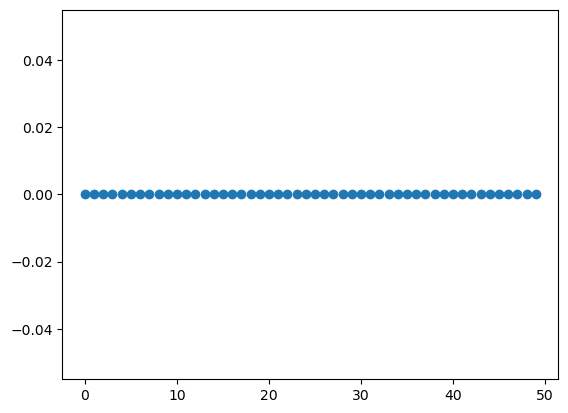

In [228]:
plt.scatter(np.arange(epochs), avg_test_losses)

In [288]:
N = 2000
D = 1000
sigma = 0.1
MSE_vs_N = []
start = 0
step = 10
for _ in range(0, N, 10):
    #X = torch.rand(N, D)
    X = torch.normal(mean=torch.zeros(N, D), std=torch.ones(N, D))
    beta = torch.rand(D, 1) 
    beta *= 1/torch.tensordot(beta, beta)
    Y = torch.tensordot(X, beta, dims=1) + torch.normal(mean=torch.zeros(N), std=sigma*torch.ones(N))
    dataset = torch.utils.data.TensorDataset(X, Y)
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
    
    our_model = LinearRegressionModel(D, 1)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(our_model.parameters(), lr=0.01)
    
    epochs = 1
    avg_test_losses = []
    if N % 100: 
        print(f'N is {N}')
    for t in range(epochs):
        #print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataset, our_model, criterion, optimizer)
        avg_test_loss = test_loop(test_dataset, our_model, criterion)
        avg_test_losses.append(avg_test_loss)
    MSE_vs_N.append(avg_test_losses[-1])

/opt/miniconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([2000])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


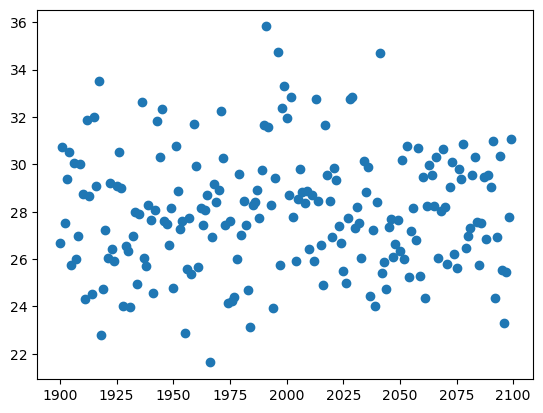

In [289]:
plt.scatter(np.arange(N-100, N+100), MSE_vs_N)

In [ ]:
plt.scatter(np.arange(N), MSE_vs_N)

In [178]:
len(avg_test_losses)

50

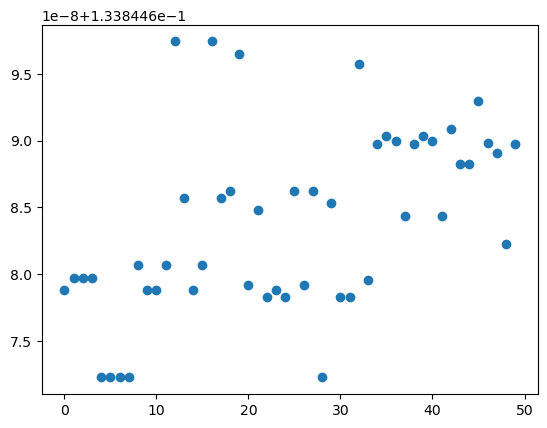

In [179]:
plt.scatter(np.arange(epochs), avg_test_losses)

In [231]:
NUM_EPOCHS = 1
losses = []
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    our_model.train()
    for i, data in enumerate(dataset):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        #print(labels)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = our_model(inputs)
        #print(outputs, labels)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        #if i % 2000 == 1999:    # print every 2000 mini-batches
        #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        losses.append(running_loss)
        running_loss = 0.0

print('Finished Training')

Finished Training


In [244]:
for param in our_model.parameters():
    print(param.data)

tensor([[0.0368, 0.0250, 0.5162, 0.3794, 0.5245, 0.5451, 0.9320, 0.0288, 0.7738]])
tensor([-2.5747e-07])


In [245]:
beta

tensor([[0.0368],
        [0.0250],
        [0.5162],
        [0.3794],
        [0.5245],
        [0.5451],
        [0.9320],
        [0.0288],
        [0.7738]])

In [135]:
total_params = sum(p.numel() for p in our_model.parameters())
total_params

4

In [129]:
len(losses)

2000

In [130]:
len(np.arange(N*NUM_EPOCHS))

2000

In [111]:
losses

[0.0007215748191811144,
 0.05006939545273781,
 0.03253050893545151,
 0.0006327654118649662,
 0.00032995178480632603,
 0.0006291811005212367,
 0.04923894256353378,
 0.03224755451083183,
 0.0006022528978064656,
 0.0003654937900137156,
 0.0005438677617348731,
 0.04842466861009598,
 0.03196702525019646,
 0.0005729907425120473,
 0.00040255917701870203,
 0.0004654589283745736,
 0.04762636497616768,
 0.03168916702270508,
 0.0005449358723126352,
 0.0004411313566379249,
 0.0003938196459785104,
 0.04684334248304367,
 0.03141423314809799,
 0.0005180381122045219,
 0.0004811488324776292,
 0.00032876190380193293,
 0.04607563465833664,
 0.03114205412566662,
 0.0004922150983475149,
 0.0005225573549978435,
 0.0002701140474528074,
 0.04532289877533913,
 0.030872713774442673,
 0.0004674362426158041,
 0.0005653149564750493,
 0.00021771385218016803,
 0.04458484798669815,
 0.030606377869844437,
 0.0004436688032001257,
 0.0006093946285545826,
 0.00017140153795480728,
 0.043860990554094315,
 0.030343065038323

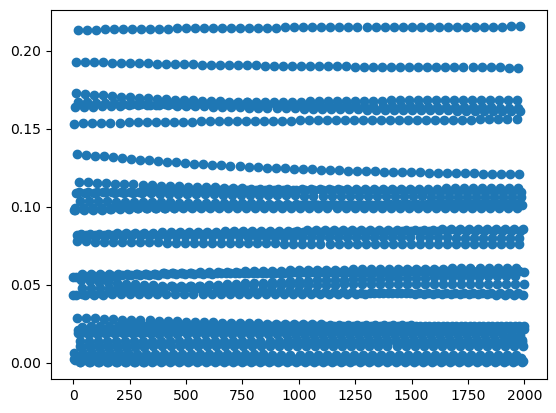

In [136]:
plt.scatter(np.arange(N*NUM_EPOCHS), losses)

In [45]:
for epoch in range(50):
 
    # Forward pass: Compute predicted y by passing 
    # x to the model
    pred_y = our_model(X)
 
    # Compute and print loss
    loss = criterion(pred_y, Y)
 
    # Zero gradients, perform a backward pass, 
    # and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('epoch {}, loss {}'.format(epoch, loss.item()))

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float